In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
#policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

In [10]:
tf.__version__

'2.1.0'

In [11]:
import pathlib
#data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                         fname='flower_photos', untar=True)

val_data_dir = '/opt/AIStorage/PLAYGROUND/images/512/validation'
val_data_dir = pathlib.Path(val_data_dir)

data_dir = '/opt/AIStorage/PLAYGROUND/images/512/train'
data_dir = pathlib.Path(data_dir)

In [12]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

8169

In [13]:
val_image_count = len(list(val_data_dir.glob('*/*.png')))
val_image_count

2047

In [14]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['positive', 'negative'], dtype='<U8')

In [15]:
#img = list(data_dir.glob('positive/*'))

#for image_path in img[:4]:
    #display.display(Image.open(str(image_path)))

In [16]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    #rescale=1./255,
                    #rotation_range=15,
                    #horizontal_flip=True,
                    #zoom_range=0.0
                    #)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255
                    )

In [17]:
BATCH_SIZE = 8
#IMG_HEIGHT = 224
#IMG_WIDTH = 224
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [18]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

validation_data_gen = val_image_generator.flow_from_directory(directory=str(val_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 8169 images belonging to 2 classes.
Found 2047 images belonging to 2 classes.


In [19]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(4):
      ax = plt.subplot(2,2,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('on')

In [20]:
#image_batch, label_batch = next(train_data_gen)
#show_batch(image_batch, label_batch)

In [21]:
#label_batch

In [22]:
#val_image_batch, val_label_batch = next(validation_data_gen)
#show_batch(val_image_batch, val_label_batch)

In [23]:
#val_label_batch

In [24]:
from tensorflow.keras.callbacks import Callback

In [25]:
class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 400, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [26]:

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
 

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            print('get lr error')
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            print('get momentum error')
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            print('set lr error')
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            print('set momentum error')
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [27]:
epochs = 20
lr = 3e-3
steps = np.ceil(image_count / BATCH_SIZE) * epochs
lr_schedule = OneCycleScheduler(lr, steps)


#optimizer = tf.keras.optimizers.RMSprop(lr=lr)
optimizer = tf.keras.optimizers.SGD(lr=lr)


In [28]:
steps

20440.0

In [29]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#base_model.trainable = False

In [30]:

 
for layer in base_model.layers:
    if layer.name.endswith('bn'):

        layer.trainable = True
    else:
        layer.trainable = False

 

# Let's take a look at the base model architecture



In [31]:
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [32]:



    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_max_layer = tf.keras.layers.GlobalMaxPool2D()
flatten = tf.keras.layers.Flatten()

batch_norm_1 = tf.keras.layers.BatchNormalization()
drop_out_1 = tf.keras.layers.Dropout(0.25)
dense_layer_1 = tf.keras.layers.Dense(512,activation='relu')

batch_norm_2 = tf.keras.layers.BatchNormalization()
drop_out_2 = tf.keras.layers.Dropout(0.5)



prediction_layer = tf.keras.layers.Dense(2)

model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      #global_max_layer,
      flatten,
      batch_norm_1,
      drop_out_1,
      dense_layer_1,
      batch_norm_2,
      drop_out_2,
      prediction_layer
])

    
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 16, 16, 1664)      12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               852480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [33]:
#lr_finder = LRFinder()

In [34]:
# _ = model.fit_generator(train_data_gen,
#                    epochs=1,
#                    validation_data=validation_data_gen, 
#                    steps_per_epoch=STEPS_PER_EPOCH, 
#                    validation_steps=VAL_STEPS_PER_EPOCH,
#                    callbacks=[lr_finder])

In [35]:
#lr_finder.plot() 

In [36]:
history = model.fit_generator(train_data_gen,
                    epochs=epochs,
                    validation_data=validation_data_gen, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[lr_schedule])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1022.0 steps, validate for 256.0 steps
Epoch 1/20
1022/1022 [==============================] - 306s 300ms/step - loss: 0.9924 - accuracy: 0.5207 - val_loss: 0.8205 - val_accuracy: 0.5620
Epoch 2/20
1022/1022 [==============================] - 283s 277ms/step - loss: 0.8339 - accuracy: 0.6034 - val_loss: 0.6398 - val_accuracy: 0.6900
Epoch 3/20
1022/1022 [==============================] - 283s 277ms/step - loss: 0.7019 - accuracy: 0.6667 - val_loss: 0.5485 - val_accuracy: 0.7377
Epoch 4/20
1022/1022 [==============================] - 283s 277ms/step - loss: 0.5907 - accuracy: 0.7187 - val_loss: 0.4797 - val_accuracy: 0.7653
Epoch 5/20
1022/1022 [==============================] - 283s 277ms/step - loss: 0.5061 - accuracy: 0.7646 - val_loss: 0.4839 - val_accuracy: 0.7877
Epoch 6/20
1022/1022 [==============================] - 283s 277ms/step - loss: 0.436

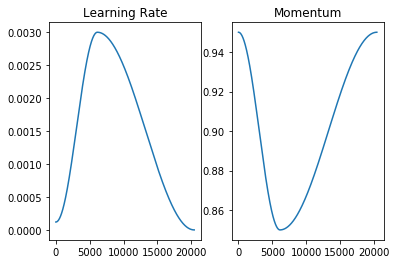

In [37]:
lr_schedule.plot()

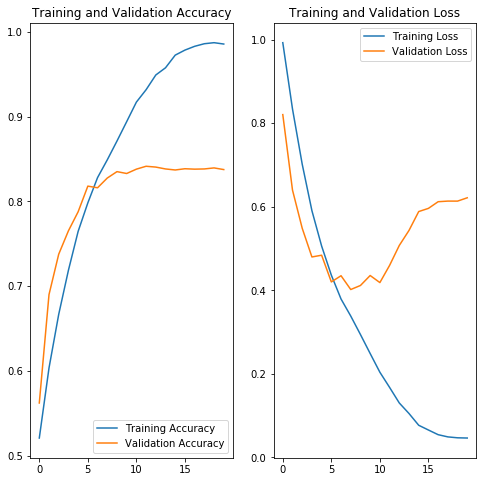

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
#Load using tf.data

In [40]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

In [41]:
for f in list_ds.take(5):
  print(f.numpy())

b'/opt/AIStorage/PLAYGROUND/images/512/train/positive/2.25.56615879840857716743520778794392745124.png'
b'/opt/AIStorage/PLAYGROUND/images/512/train/positive/2.25.99646917028845672410625354702076980042.png'
b'/opt/AIStorage/PLAYGROUND/images/512/train/positive/2.25.65873202867829749579391919908075947003.png'
b'/opt/AIStorage/PLAYGROUND/images/512/train/negative/2.25.261286134942620995132615571510440549202.png'
b'/opt/AIStorage/PLAYGROUND/images/512/train/negative/2.25.275278124750177147956680613868673675909.png'


In [42]:
for f in val_list_ds.take(5):
  print(f.numpy())

b'/opt/AIStorage/PLAYGROUND/images/512/validation/positive/2.25.124602844038666176572701959541382901395.png'
b'/opt/AIStorage/PLAYGROUND/images/512/validation/positive/2.25.170946295663038650111663576571500464975.png'
b'/opt/AIStorage/PLAYGROUND/images/512/validation/positive/2.25.49328626025572507054828410089596158780.png'
b'/opt/AIStorage/PLAYGROUND/images/512/validation/negative/2.25.222248806033556467942806620334735082427.png'
b'/opt/AIStorage/PLAYGROUND/images/512/validation/positive/2.25.180063703721282385305673784000766149312.png'


In [43]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = 0
  else:
    label = 1
  return label

In [44]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [45]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [46]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [47]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  

Image shape:  (512, 512, 3)
Label:  1


In [48]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  0


In [49]:
def prepare_for_training(ds, shuffle=True, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [50]:
train_ds = prepare_for_training(labeled_ds)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds

image_batch, label_batch = next(iter(train_ds))

In [51]:
#show_batch(image_batch.numpy(), label_batch.numpy())

In [52]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)



mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():

    base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    for layer in base_model.layers:
        if layer.name.endswith('bn'):
            layer.trainable = True
        else:
            layer.trainable = False
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(feature_batch_average.shape)

    
    dense_layer_1 = tf.keras.layers.Dense(2048,activation='relu')
    drop_out_1 = tf.keras.layers.Dropout(0.3)
    dense_layer_2 = tf.keras.layers.Dense(2048,activation='relu')
    drop_out_2 = tf.keras.layers.Dropout(0.3)
    prediction_layer = tf.keras.layers.Dense(1)
    #prediction_batch = prediction_layer(feature_batch_average)
    #print(prediction_batch.shape)

    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      dense_layer_1,
      drop_out_1,
      dense_layer_2,
      drop_out_2,
      prediction_layer
    ])

    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


    model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [53]:
history = model.fit(train_ds,
                    epochs=2,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH)


Train for 1022.0 steps, validate for 256.0 steps
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
1022/1022 [==============================] - 264s 258ms/step - loss: 0.5565 - accuracy: 0.7261 - val_loss: 0.3679 - val_accuracy: 0.8359
Epoch 2/20
1022/1022 [==============================] - 185s 181ms/step - loss: 0.4275 - accuracy: 0.8233 - val_loss: 0.3735 - val_accuracy: 0.8486
Epoch 3/20
1022/1022 [==============================] - 185s 181ms/step - loss: 0.3872 - accuracy: 0.8467 - val_loss: 0.3610 - val_accuracy: 0.8491
Epoch 4/20
1022/1022 [==============================] - 185s 181ms/step - loss: 0.3400 - accuracy: 0.8641 - val_loss: 0.3517 - val_accuracy: 0.8311
Epoch 5/20
1022/1022 [==============================]

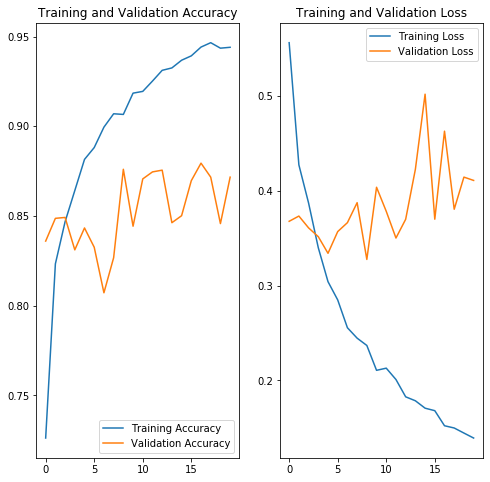

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()